 # Covid-19 Cases Prediction

Following are the criteria of the model.
1) Only LSTM, Dense, and Dropout layers should be implemented in the model.
2) Nodes in the LSTM layers should be ≤ 64, however, the depth of the model can be set according to your needs.
3) Window size should be set to 30 days.
4) MAPE error should be lesser than 1% when tested against testing dataset.
𝑀𝑒𝑎𝑛 𝐴𝑏𝑠𝑜𝑙𝑢𝑡𝑒 𝑃𝑒𝑟𝑐𝑒𝑛𝑡𝑎𝑔𝑒 𝐸𝑟𝑟𝑜𝑟= 𝑀𝑒𝑎𝑛 𝐴𝑏𝑠𝑜𝑙𝑢𝑡𝑒 𝐸𝑟𝑟𝑜𝑟𝑠𝑢𝑚(𝑎𝑏𝑠(𝑦_𝑎𝑐𝑡𝑢𝑎𝑙))∗100%
5) Training loss should be displayed using TensorBoard.
*Tips: You do not need to include validation data in model.fit() during training.

#### 1. Import packages

In [1]:
import os
import datetime
import IPython
import numpy as np
import pandas as pd
import seaborn as sns
import IPython.display
import tensorflow as tf
import matplotlib as mpl
from tensorflow import keras
import matplotlib.pyplot as plt
from wg_class import WindowGenerator
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler


mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

#### 2. Load the data file

In [2]:
# Load the data
TRAIN_CSV_PATH = os.path.join(os.getcwd(), 'cases_malaysia_train.csv')
TEST_CSV_PATH = os.path.join(os.getcwd(), 'cases_malaysia_test.csv')

In [3]:
train_df = pd.read_csv(TRAIN_CSV_PATH) 
test_df = pd.read_csv(TEST_CSV_PATH) 

#### 3. Data inspection

#### train dataset

In [4]:
train_df.head()

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_unvax,cases_pvax,cases_fvax,cases_boost,...,cases_60_69,cases_70_79,cases_80,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
0,25/1/2020,4,4,0,4,0,4,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26/1/2020,0,0,0,4,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27/1/2020,0,0,0,4,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,28/1/2020,0,0,0,4,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,29/1/2020,3,3,0,7,0,3,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cases_import,680.0,8.788235,9.162540,0.0,3.00,6.0,12.00,72.0
cases_recovered,680.0,3766.514706,5622.296192,0.0,46.50,1201.5,5173.50,24855.0
cases_active,680.0,45733.016176,67888.984001,1.0,1158.25,14371.0,64899.25,263845.0
cases_cluster,680.0,717.130882,827.327827,0.0,13.00,417.5,1117.75,3394.0
cases_unvax,680.0,2452.023529,3191.392812,0.0,46.50,1257.5,3462.50,12684.0
cases_pvax,680.0,578.805882,1532.323940,0.0,0.00,0.0,118.25,7313.0
cases_fvax,680.0,868.045588,1877.386774,0.0,0.00,0.0,116.50,8456.0
cases_boost,680.0,4.763235,21.433285,0.0,0.00,0.0,0.00,170.0
cases_child,680.0,519.935294,831.685231,0.0,2.00,109.0,754.25,3437.0
cases_adolescent,680.0,261.016176,433.549560,0.0,2.00,63.0,304.00,1820.0


In [6]:
# Check for missing values in the data
train_df.isnull().sum()

date                         0
cases_new                    0
cases_import                 0
cases_recovered              0
cases_active                 0
cases_cluster                0
cases_unvax                  0
cases_pvax                   0
cases_fvax                   0
cases_boost                  0
cases_child                  0
cases_adolescent             0
cases_adult                  0
cases_elderly                0
cases_0_4                    0
cases_5_11                   0
cases_12_17                  0
cases_18_29                  0
cases_30_39                  0
cases_40_49                  0
cases_50_59                  0
cases_60_69                  0
cases_70_79                  0
cases_80                     0
cluster_import             342
cluster_religious          342
cluster_community          342
cluster_highRisk           342
cluster_education          342
cluster_detentionCentre    342
cluster_workplace          342
dtype: int64

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     680 non-null    object 
 1   cases_new                680 non-null    object 
 2   cases_import             680 non-null    int64  
 3   cases_recovered          680 non-null    int64  
 4   cases_active             680 non-null    int64  
 5   cases_cluster            680 non-null    int64  
 6   cases_unvax              680 non-null    int64  
 7   cases_pvax               680 non-null    int64  
 8   cases_fvax               680 non-null    int64  
 9   cases_boost              680 non-null    int64  
 10  cases_child              680 non-null    int64  
 11  cases_adolescent         680 non-null    int64  
 12  cases_adult              680 non-null    int64  
 13  cases_elderly            680 non-null    int64  
 14  cases_0_4                6

#### test dataset

In [8]:
test_df.head()

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_unvax,cases_pvax,cases_fvax,cases_boost,...,cases_60_69,cases_70_79,cases_80,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
0,5/12/2021,4298.0,23,4928,61813,136,1017,38,3093,150,...,330,130,49,0,13,3,12,69,0,39
1,6/12/2021,4262.0,15,5894,60139,97,1036,39,3056,131,...,352,141,49,0,10,0,2,30,0,55
2,7/12/2021,4965.0,29,4817,60251,138,1130,46,3642,147,...,395,169,81,0,3,13,39,36,0,47
3,8/12/2021,5020.0,17,4525,60709,154,1162,41,3674,143,...,378,154,43,0,2,3,0,32,1,116
4,9/12/2021,5446.0,20,5427,60700,367,1207,53,4034,152,...,367,161,46,0,0,1,8,153,0,205


In [9]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cases_new,99.0,11973.808081,11090.623017,2342.0,3438.00,4774.0,22951.00,33406.0
cases_import,100.0,224.990000,153.883105,14.0,94.75,218.5,334.25,608.0
cases_recovered,100.0,9415.300000,9226.279561,2584.0,3398.50,4753.5,11930.00,33872.0
cases_active,100.0,120021.370000,106310.747283,39615.0,42808.25,57657.5,221429.25,323618.0
cases_cluster,100.0,320.790000,225.743678,33.0,131.75,279.0,483.25,1019.0
cases_unvax,100.0,2087.390000,1717.484212,489.0,740.75,1031.5,3846.75,5649.0
cases_pvax,100.0,142.730000,207.250293,11.0,19.00,30.5,175.25,773.0
cases_fvax,100.0,5294.580000,3781.993457,1573.0,2363.50,3097.0,9119.00,13079.0
cases_boost,100.0,4386.570000,5682.907255,96.0,252.00,695.0,9553.25,18123.0
cases_child,100.0,1584.260000,1387.877251,349.0,492.75,735.5,3021.75,4389.0


In [10]:
test_df.isnull().sum()

date                       0
cases_new                  1
cases_import               0
cases_recovered            0
cases_active               0
cases_cluster              0
cases_unvax                0
cases_pvax                 0
cases_fvax                 0
cases_boost                0
cases_child                0
cases_adolescent           0
cases_adult                0
cases_elderly              0
cases_0_4                  0
cases_5_11                 0
cases_12_17                0
cases_18_29                0
cases_30_39                0
cases_40_49                0
cases_50_59                0
cases_60_69                0
cases_70_79                0
cases_80                   0
cluster_import             0
cluster_religious          0
cluster_community          0
cluster_highRisk           0
cluster_education          0
cluster_detentionCentre    0
cluster_workplace          0
dtype: int64

In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     100 non-null    object 
 1   cases_new                99 non-null     float64
 2   cases_import             100 non-null    int64  
 3   cases_recovered          100 non-null    int64  
 4   cases_active             100 non-null    int64  
 5   cases_cluster            100 non-null    int64  
 6   cases_unvax              100 non-null    int64  
 7   cases_pvax               100 non-null    int64  
 8   cases_fvax               100 non-null    int64  
 9   cases_boost              100 non-null    int64  
 10  cases_child              100 non-null    int64  
 11  cases_adolescent         100 non-null    int64  
 12  cases_adult              100 non-null    int64  
 13  cases_elderly            100 non-null    int64  
 14  cases_0_4                10

#### 4. Data cleaning

#### train dataset

In [12]:
#Extract out the date
date_time = pd.to_datetime(train_df.pop('date'), format='%d/%m/%Y')

In [13]:
#Remove the '?' in 'cases_new' column
train_df['cases_new'] = train_df['cases_new'].str.replace(r'[^0-9a-zA-Z:,]+', '')

In [14]:
# Convert 'cases_new' column to numeric, converting non-numeric values to NaN
train_df['cases_new'] = pd.to_numeric(train_df['cases_new'], errors='coerce')

In [15]:
# Replace missing values in 'cases_new' column with mean
# Calculate the mean of the 'cases_new' column
mean_cases_new = train_df['cases_new'].mean()

# Fill missing values in the 'cases_new' column with the calculated mean
train_df['cases_new'] = train_df['cases_new'].fillna(mean_cases_new)

In [16]:
# Calculate the means of the columns contain missing values to be imputed
mean_cluster_religious = train_df['cluster_import'].mean()
mean_cluster_religious = train_df['cluster_religious'].mean()
mean_cluster_community = train_df['cluster_community'].mean()
mean_cluster_highRisk = train_df['cluster_highRisk'].mean()
mean_cluster_education = train_df['cluster_education'].mean()
mean_cluster_detentionCentre = train_df['cluster_detentionCentre'].mean()
mean_cluster_workplace = train_df['cluster_workplace'].mean()

# Fill missing values in the respective columns with the calculated mean values
train_df['cluster_import'] = train_df['cluster_import'].fillna(mean_cluster_religious)
train_df['cluster_religious'] = train_df['cluster_religious'].fillna(mean_cluster_religious)
train_df['cluster_community'] = train_df['cluster_community'].fillna(mean_cluster_community)
train_df['cluster_highRisk'] = train_df['cluster_highRisk'].fillna(mean_cluster_highRisk)
train_df['cluster_education'] = train_df['cluster_education'].fillna(mean_cluster_education)
train_df['cluster_detentionCentre'] = train_df['cluster_detentionCentre'].fillna(mean_cluster_detentionCentre)
train_df['cluster_workplace'] = train_df['cluster_workplace'].fillna(mean_cluster_workplace)


In [17]:
train_df.head()

,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_unvax,cases_pvax,cases_fvax,cases_boost,cases_child,...,cases_60_69,cases_70_79,cases_80,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
0,4.0,4,0,4,0,4,0,0,0,0,...,0,0,0,24.988166,24.988166,214.372781,28.544379,38.594675,65.174556,670.340237
1,0.0,0,0,4,0,0,0,0,0,0,...,0,0,0,24.988166,24.988166,214.372781,28.544379,38.594675,65.174556,670.340237
2,0.0,0,0,4,0,0,0,0,0,0,...,0,0,0,24.988166,24.988166,214.372781,28.544379,38.594675,65.174556,670.340237
3,0.0,0,0,4,0,0,0,0,0,0,...,0,0,0,24.988166,24.988166,214.372781,28.544379,38.594675,65.174556,670.340237
4,3.0,3,0,7,0,3,0,0,0,1,...,0,0,0,24.988166,24.988166,214.372781,28.544379,38.594675,65.174556,670.340237


In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cases_new                680 non-null    float64
 1   cases_import             680 non-null    int64  
 2   cases_recovered          680 non-null    int64  
 3   cases_active             680 non-null    int64  
 4   cases_cluster            680 non-null    int64  
 5   cases_unvax              680 non-null    int64  
 6   cases_pvax               680 non-null    int64  
 7   cases_fvax               680 non-null    int64  
 8   cases_boost              680 non-null    int64  
 9   cases_child              680 non-null    int64  
 10  cases_adolescent         680 non-null    int64  
 11  cases_adult              680 non-null    int64  
 12  cases_elderly            680 non-null    int64  
 13  cases_0_4                680 non-null    int64  
 14  cases_5_11               6

In [19]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cases_new,680.0,3899.392216,5603.602481,0.0,47.00,1365.500000,5414.500000,24599.0
cases_import,680.0,8.788235,9.162540,0.0,3.00,6.000000,12.000000,72.0
cases_recovered,680.0,3766.514706,5622.296192,0.0,46.50,1201.500000,5173.500000,24855.0
cases_active,680.0,45733.016176,67888.984001,1.0,1158.25,14371.000000,64899.250000,263845.0
cases_cluster,680.0,717.130882,827.327827,0.0,13.00,417.500000,1117.750000,3394.0
cases_unvax,680.0,2452.023529,3191.392812,0.0,46.50,1257.500000,3462.500000,12684.0
cases_pvax,680.0,578.805882,1532.323940,0.0,0.00,0.000000,118.250000,7313.0
cases_fvax,680.0,868.045588,1877.386774,0.0,0.00,0.000000,116.500000,8456.0
cases_boost,680.0,4.763235,21.433285,0.0,0.00,0.000000,0.000000,170.0
cases_child,680.0,519.935294,831.685231,0.0,2.00,109.000000,754.250000,3437.0


#### test dataset

In [20]:
#Extract out the date
date_time = pd.to_datetime(test_df.pop('date'), format='%d/%m/%Y')

In [21]:
# Convert 'cases_new' column to numeric, converting non-numeric values to NaN
test_df['cases_new'] = pd.to_numeric(test_df['cases_new'], errors='coerce')

In [22]:
# Replace missing values in 'cases_new' column with mean
# Calculate the mean of the 'cases_new' column
mean_cases_new_test = test_df['cases_new'].mean()

# Fill missing values in the 'cases_new' column with the calculated mean
test_df['cases_new'] = test_df['cases_new'].fillna(mean_cases_new_test)

In [23]:
test_df.head()

,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_unvax,cases_pvax,cases_fvax,cases_boost,cases_child,...,cases_60_69,cases_70_79,cases_80,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
0,4298.0,23,4928,61813,136,1017,38,3093,150,734,...,330,130,49,0,13,3,12,69,0,39
1,4262.0,15,5894,60139,97,1036,39,3056,131,707,...,352,141,49,0,10,0,2,30,0,55
2,4965.0,29,4817,60251,138,1130,46,3642,147,763,...,395,169,81,0,3,13,39,36,0,47
3,5020.0,17,4525,60709,154,1162,41,3674,143,768,...,378,154,43,0,2,3,0,32,1,116
4,5446.0,20,5427,60700,367,1207,53,4034,152,840,...,367,161,46,0,0,1,8,153,0,205


In [24]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cases_new                100 non-null    float64
 1   cases_import             100 non-null    int64  
 2   cases_recovered          100 non-null    int64  
 3   cases_active             100 non-null    int64  
 4   cases_cluster            100 non-null    int64  
 5   cases_unvax              100 non-null    int64  
 6   cases_pvax               100 non-null    int64  
 7   cases_fvax               100 non-null    int64  
 8   cases_boost              100 non-null    int64  
 9   cases_child              100 non-null    int64  
 10  cases_adolescent         100 non-null    int64  
 11  cases_adult              100 non-null    int64  
 12  cases_elderly            100 non-null    int64  
 13  cases_0_4                100 non-null    int64  
 14  cases_5_11               10

In [25]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cases_new,100.0,11973.808081,11034.467603,2342.0,3464.00,4844.5,22876.50,33406.0
cases_import,100.0,224.990000,153.883105,14.0,94.75,218.5,334.25,608.0
cases_recovered,100.0,9415.300000,9226.279561,2584.0,3398.50,4753.5,11930.00,33872.0
cases_active,100.0,120021.370000,106310.747283,39615.0,42808.25,57657.5,221429.25,323618.0
cases_cluster,100.0,320.790000,225.743678,33.0,131.75,279.0,483.25,1019.0
cases_unvax,100.0,2087.390000,1717.484212,489.0,740.75,1031.5,3846.75,5649.0
cases_pvax,100.0,142.730000,207.250293,11.0,19.00,30.5,175.25,773.0
cases_fvax,100.0,5294.580000,3781.993457,1573.0,2363.50,3097.0,9119.00,13079.0
cases_boost,100.0,4386.570000,5682.907255,96.0,252.00,695.0,9553.25,18123.0
cases_child,100.0,1584.260000,1387.877251,349.0,492.75,735.5,3021.75,4389.0


#### 5. Data splitting

In [26]:
#Dictionary to hold the column names and their index as key-value pair
#70:20:10 split
n = len(train_df)
train_df_split = train_df[0:int(n*0.7)]
val_df = train_df[int(n*0.7):int(n*0.9)]
test_df = train_df[int(n*0.9):]

#### 5. Data normalization

In [27]:
#Extract out the column names
column_names = train_df.columns.values

In [28]:
mms = MinMaxScaler()
train_df_normalized = mms.fit_transform(train_df)
val_df_normalized = mms.transform(val_df)
test_df_normalized = mms.transform(test_df)

In [29]:
#scaler returns ndarray, convert it back to DataFrame
train_df = pd.DataFrame(train_df_normalized, columns=column_names)
val_df = pd.DataFrame(val_df_normalized, columns=column_names)
test_df = pd.DataFrame(test_df_normalized, columns=column_names)

In [30]:
train_df.head()

,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_unvax,cases_pvax,cases_fvax,cases_boost,cases_child,...,cases_60_69,cases_70_79,cases_80,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
0,0.000163,0.055556,0.0,0.000011,0.0,0.000315,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.462744,0.069605,0.259846,0.151028,0.077035,0.148461,0.277131
1,0.000000,0.000000,0.0,0.000011,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.462744,0.069605,0.259846,0.151028,0.077035,0.148461,0.277131
2,0.000000,0.000000,0.0,0.000011,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.462744,0.069605,0.259846,0.151028,0.077035,0.148461,0.277131
3,0.000000,0.000000,0.0,0.000011,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.462744,0.069605,0.259846,0.151028,0.077035,0.148461,0.277131
4,0.000122,0.041667,0.0,0.000023,0.0,0.000237,0.0,0.0,0.0,0.000291,...,0.0,0.0,0.0,0.462744,0.069605,0.259846,0.151028,0.077035,0.148461,0.277131


In [31]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cases_new,680.0,0.158518,0.227798,0.0,0.001911,0.055510,0.220111,1.0
cases_import,680.0,0.122059,0.127258,0.0,0.041667,0.083333,0.166667,1.0
cases_recovered,680.0,0.151540,0.226204,0.0,0.001871,0.048340,0.208147,1.0
cases_active,680.0,0.173330,0.257307,0.0,0.004386,0.054464,0.245972,1.0
cases_cluster,680.0,0.211294,0.243762,0.0,0.003830,0.123011,0.329331,1.0
cases_unvax,680.0,0.193316,0.251608,0.0,0.003666,0.099141,0.272982,1.0
cases_pvax,680.0,0.079148,0.209534,0.0,0.000000,0.000000,0.016170,1.0
cases_fvax,680.0,0.102654,0.222018,0.0,0.000000,0.000000,0.013777,1.0
cases_boost,680.0,0.028019,0.126078,0.0,0.000000,0.000000,0.000000,1.0
cases_child,680.0,0.151276,0.241980,0.0,0.000582,0.031714,0.219450,1.0


#### 7. Data windowing

In [32]:
single_window = WindowGenerator(input_width=30,
label_width=30, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['cases_new'])

multi_window = WindowGenerator(input_width=30,
label_width=30, shift=30, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['cases_new'])

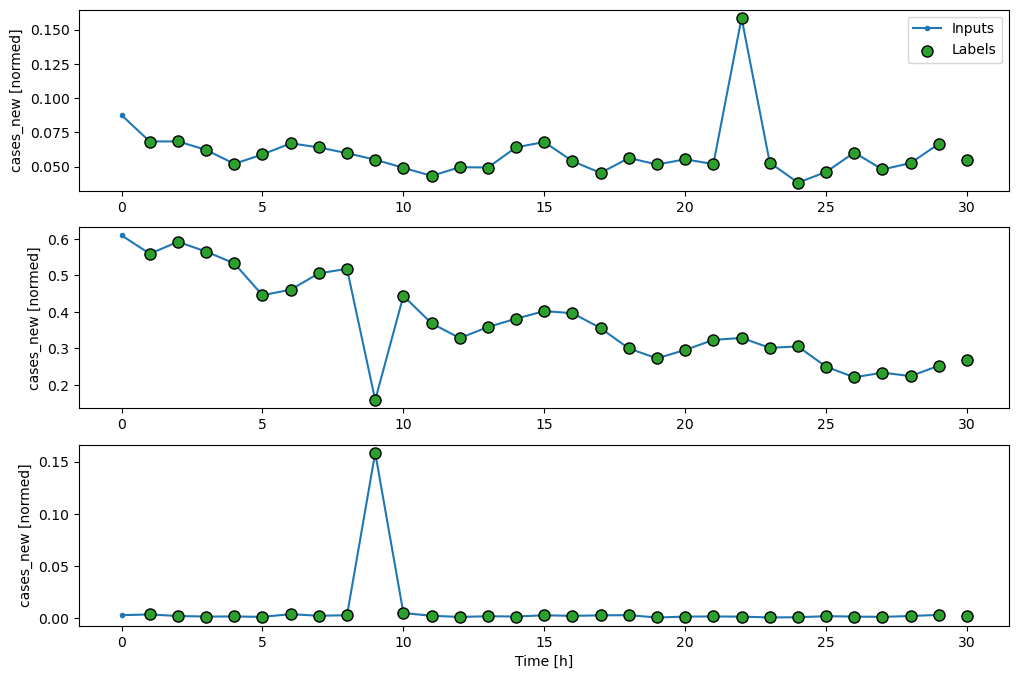

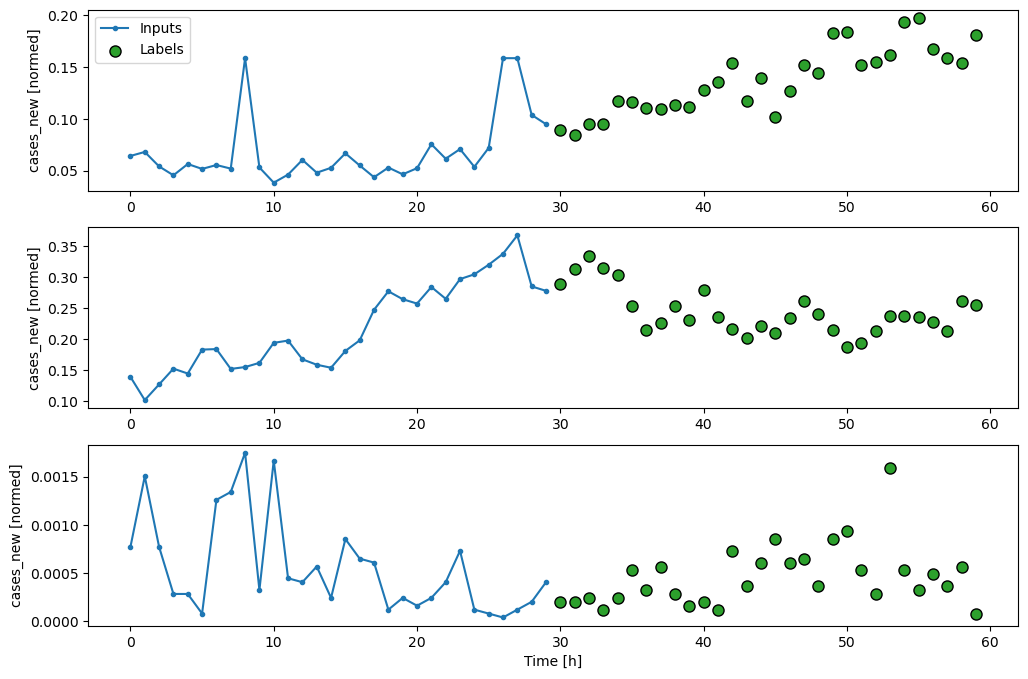

In [33]:
#plot example to check the window indexes
single_window.plot(plot_col='cases_new')
multi_window.plot(plot_col='cases_new')

Creating a TensorBoard object

In [34]:
base_log_path = r"tensorboard_logs\Capstone_Project_1"
log_path = os.path.join(base_log_path,datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb = callbacks.TensorBoard(log_path)

#### 8. Model development

#### Single-step model

In [35]:
single_model = keras.models.Sequential()
single_model.add(keras.layers.LSTM(64,return_sequences=True))
single_model.add(keras.layers.Dropout(0.2))
single_model.add(keras.layers.LSTM(64, return_sequences=True))
single_model.add(keras.layers.Dropout(0.2))
single_model.add(keras.layers.LSTM(64, return_sequences=True))  
single_model.add(keras.layers.Dropout(0.2))
single_model.add(keras.layers.LSTM(32, return_sequences=True))  
single_model.add(keras.layers.Dropout(0.2))
single_model.add(keras.layers.Dense(32, activation='tanh'))
single_model.add(keras.layers.Dense(1))


In [36]:
#compile the model
optimizer = Adam(learning_rate=0.001)
single_model.compile(optimizer=optimizer,loss='mse',metrics=['mae'])

In [37]:
#Model training
early_stopping = keras.callbacks.EarlyStopping(monitor='loss',patience=15)

history_single = single_model.fit(single_window.train,
                                   validation_data=single_window.val, 
                                   epochs=300, batch_size=200,callbacks=[early_stopping,tb]) 

Epoch 1/300
21/21 [==============================] - 14s 157ms/step - loss: 0.0208 - mae: 0.0826 - val_loss: 0.0360 - val_mae: 0.1138
Epoch 2/300
21/21 [==============================] - 1s 54ms/step - loss: 0.0112 - mae: 0.0609 - val_loss: 0.0289 - val_mae: 0.0977
Epoch 3/300
21/21 [==============================] - 1s 55ms/step - loss: 0.0088 - mae: 0.0526 - val_loss: 0.0248 - val_mae: 0.0919
Epoch 4/300
21/21 [==============================] - 1s 70ms/step - loss: 0.0077 - mae: 0.0478 - val_loss: 0.0223 - val_mae: 0.0889
Epoch 5/300
21/21 [==============================] - 1s 62ms/step - loss: 0.0069 - mae: 0.0455 - val_loss: 0.0191 - val_mae: 0.0799
Epoch 6/300
21/21 [==============================] - 1s 53ms/step - loss: 0.0063 - mae: 0.0431 - val_loss: 0.0173 - val_mae: 0.0755
Epoch 7/300
21/21 [==============================] - 1s 49ms/step - loss: 0.0060 - mae: 0.0424 - val_loss: 0.0150 - val_mae: 0.0702
Epoch 8/300
21/21 [==============================] - 1s 52ms/step - loss: 

In [38]:
#check the performance of the model
single_model.evaluate(single_window.test)

2/2 [==============================] - 0s 9ms/step - loss: 5.3279e-04 - mae: 0.0147


[0.0005327872349880636, 0.014653177000582218]

In [39]:
# Use the test data to make predictions for the single-step model
features_single, labels_single = next(iter(single_window.test.take(1)))  # Take one batch for evaluation
predictions_single = single_model.predict(features_single)

# Calculate MAPE error for the single-step model
mape_error_single = np.mean(np.abs((labels_single - predictions_single) / labels_single)) * 100
print(f"MAPE error for single-step model: {mape_error_single:.2f}%")

1/1 [==============================] - 1s 1s/step
MAPE error for single-step model: 6.45%


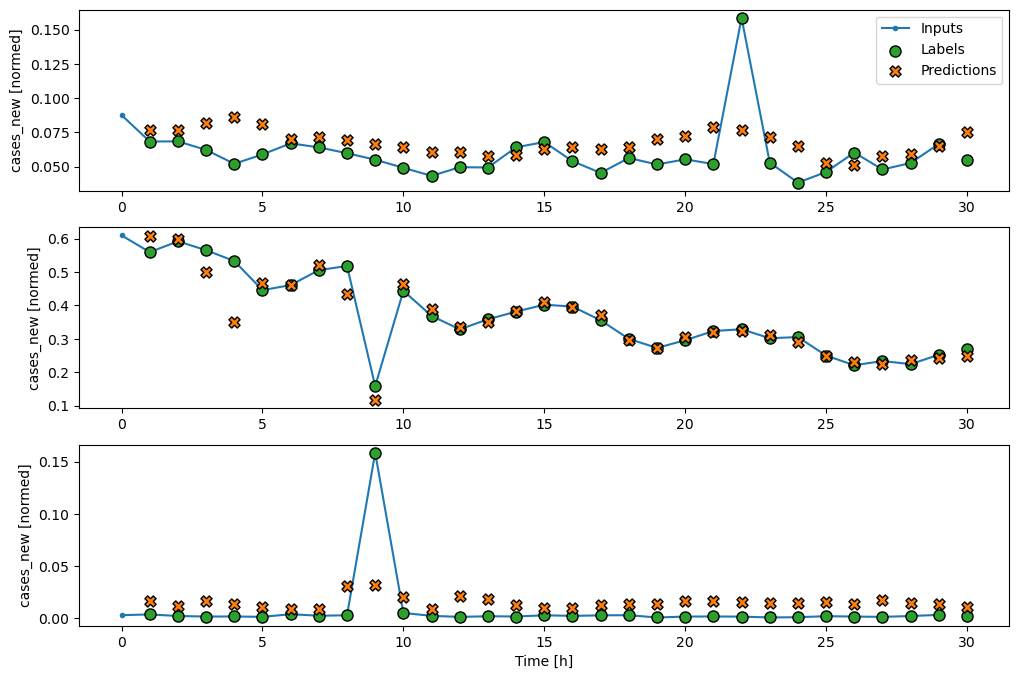

In [40]:
single_window.plot(single_model, plot_col='cases_new')

#### Multi-step model

In [41]:
multi_model = keras.models.Sequential()
multi_model.add(keras.layers.LSTM(64, return_sequences=True))
multi_model.add(keras.layers.Dropout(0.2))
multi_model.add(keras.layers.LSTM(64, return_sequences=True))
multi_model.add(keras.layers.Dropout(0.2))
multi_model.add(keras.layers.LSTM(64, return_sequences=True))
multi_model.add(keras.layers.Dropout(0.2))
multi_model.add(keras.layers.LSTM(64, return_sequences=True))
multi_model.add(keras.layers.Dropout(0.2))
multi_model.add(keras.layers.LSTM(32, return_sequences=False))
multi_model.add(keras.layers.Dropout(0.2))
multi_model.add(keras.layers.Dense(30*1,activation='tanh'))
multi_model.add(keras.layers.Reshape([30,1]))

In [42]:
#compile the model
multi_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [43]:
history_multi = multi_model.fit(multi_window.train, 
                                validation_data=multi_window.val, epochs=300, batch_size=200, callbacks=[early_stopping,tb])

Epoch 1/300
20/20 [==============================] - 16s 164ms/step - loss: 0.0315 - mae: 0.1067 - val_loss: 0.0450 - val_mae: 0.1722
Epoch 2/300
20/20 [==============================] - 1s 61ms/step - loss: 0.0113 - mae: 0.0651 - val_loss: 0.0176 - val_mae: 0.0956
Epoch 3/300
20/20 [==============================] - 1s 68ms/step - loss: 0.0069 - mae: 0.0530 - val_loss: 0.0153 - val_mae: 0.0908
Epoch 4/300
20/20 [==============================] - 1s 64ms/step - loss: 0.0055 - mae: 0.0454 - val_loss: 0.0128 - val_mae: 0.0797
Epoch 5/300
20/20 [==============================] - 1s 66ms/step - loss: 0.0046 - mae: 0.0429 - val_loss: 0.0114 - val_mae: 0.0713
Epoch 6/300
20/20 [==============================] - 1s 65ms/step - loss: 0.0039 - mae: 0.0394 - val_loss: 0.0093 - val_mae: 0.0614
Epoch 7/300
20/20 [==============================] - 1s 64ms/step - loss: 0.0040 - mae: 0.0379 - val_loss: 0.0115 - val_mae: 0.0745
Epoch 8/300
20/20 [==============================] - 1s 70ms/step - loss: 

In [44]:
#evaluate the model with test data
multi_model.evaluate(multi_window.test)

1/1 [==============================] - 0s 95ms/step - loss: 7.3656e-04 - mae: 0.0233


[0.0007365575293079019, 0.02328469604253769]

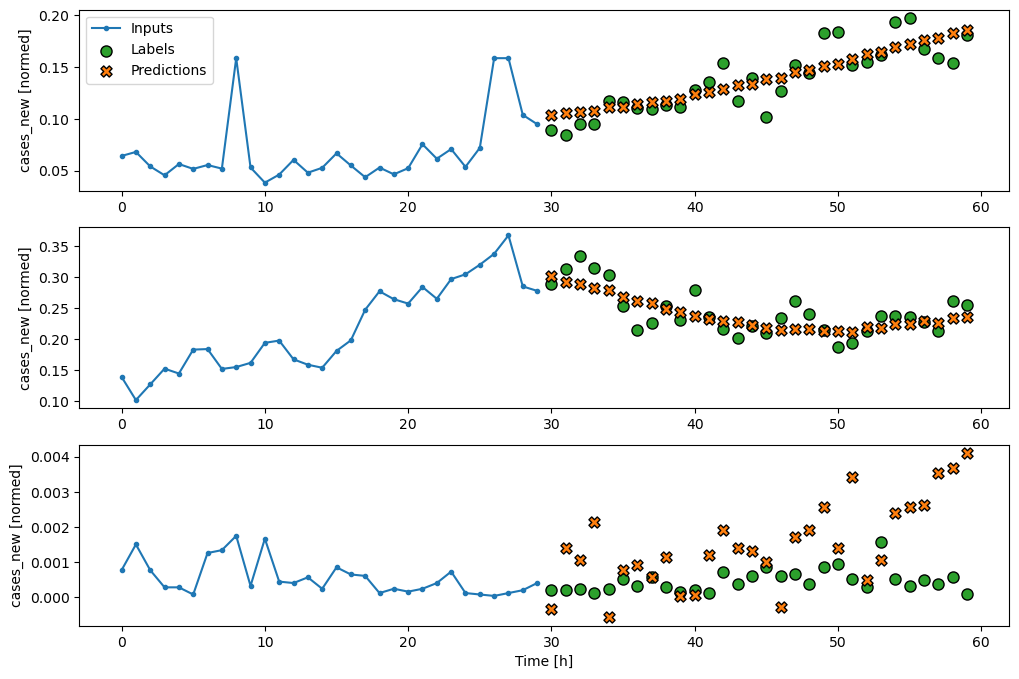

In [45]:
#plot the result
multi_window.plot(multi_model, plot_col='cases_new')

In [46]:
#Use the test data to make predictions
features, labels = next(iter(multi_window.test))
predictions = multi_model.predict(multi_window.test)

1/1 [==============================] - 2s 2s/step


In [47]:
# Calculate MAPE error
mape_error_multi = np.mean(np.abs((labels - predictions) / labels)) * 100
print(f"MAPE error for multi-step model: {mape_error_multi:.2f}%")

MAPE error for multi-step model: 10.99%


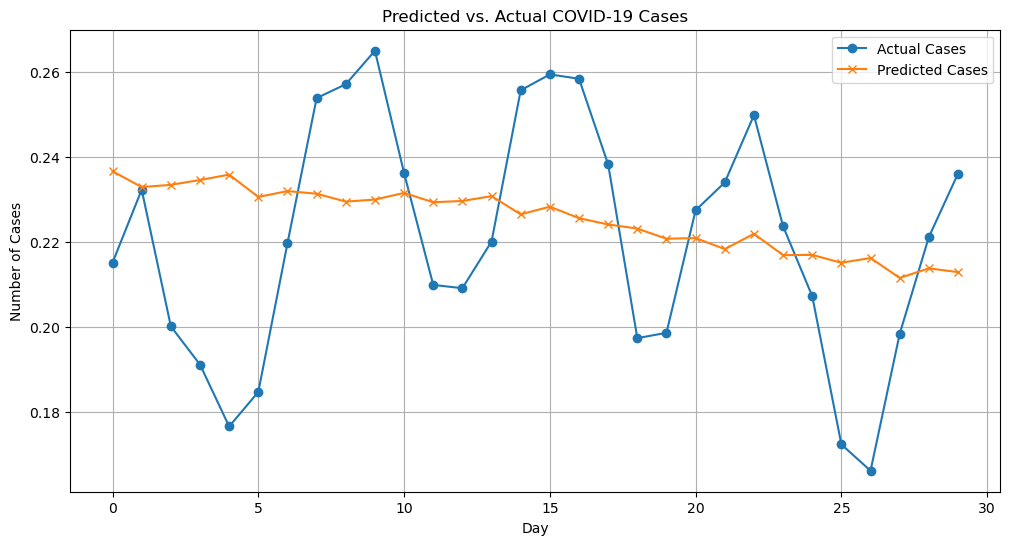

In [48]:
# Plot the predicted and actual COVID-19 cases for the first sample in the test dataset
plt.figure(figsize=(12, 6))
plt.plot(np.arange(30), labels[0, :, 0], label='Actual Cases', marker='o')
plt.plot(np.arange(30), predictions[0, :, 0], label='Predicted Cases', marker='x')
plt.xlabel('Day')
plt.ylabel('Number of Cases')
plt.title('Predicted vs. Actual COVID-19 Cases')
plt.legend()
plt.grid(True)
plt.show()


In [49]:
predictions.shape

(9, 30, 1)

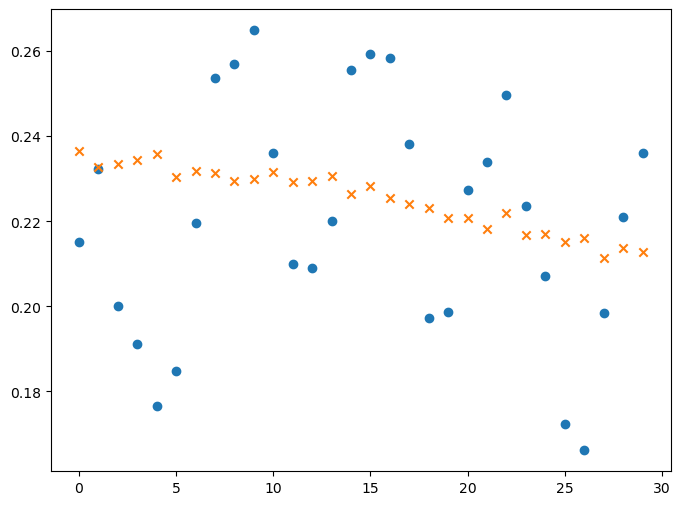

In [50]:
plt.figure()
plt.scatter(np.arange(30),labels[0, :, 0])
plt.scatter(np.arange(30),predictions[0, :, 0], marker='x')

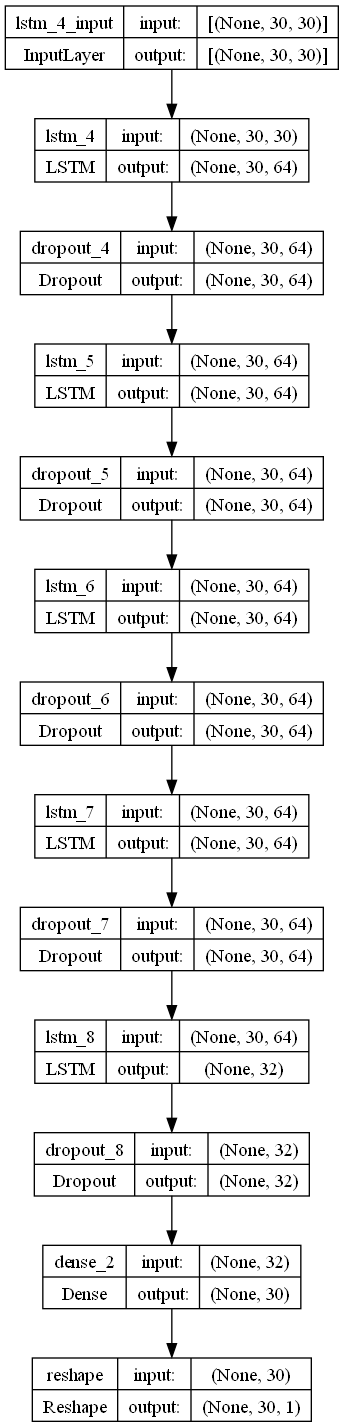

In [51]:
#Plot the architecture of the LSTM model

from keras.utils.vis_utils import plot_model
keras.utils.plot_model(multi_model)
plot_model(multi_model, to_file='model.png', show_shapes=True)